### This notebook is an in-depth study of black-box stochastic variational inference for the case of a 1-d Gauss

In [1]:
import edward as ed
import tensorflow as tf

from edward.models import Normal, InverseGamma, Uniform
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from scipy.stats import norm


In [2]:
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

import bijectors as bijector

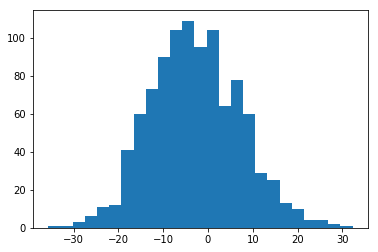

In [3]:
N = 1000
M = 100
mu_true = -3.1415
sigma_true = 10.
x_train = np.random.randn(N)*sigma_true + mu_true
x_test = np.random.randn(N)*sigma_true + mu_true
plt.hist(x_train,'auto');
mu_mle, sigma_mle = x_train.mean(),x_train.std()

In [4]:
mu_mle

-2.8035426171441387

In [5]:
sigma_mle

10.072771449862861

In [6]:
mu = Normal([0.], [10.])
sigma = InverseGamma([.01],[10.]) # this prior is too strong
x = Normal(tf.tile(mu, [M]), tf.tile(sigma,[M]))

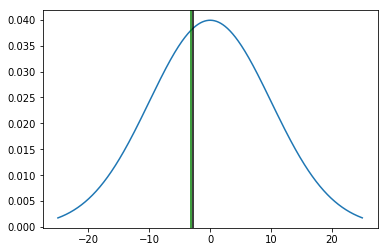

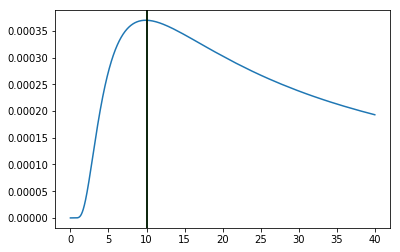

In [7]:
mus = np.arange(-25.,25,0.001,dtype=np.float32)
mu_density = mu.prob(mus)
sigmas = np.arange(0.,40,0.001,dtype=np.float32)
sigma_density = sigma.prob(sigmas)
sess = ed.get_session()
mu_density, sigma_density = sess.run([mu_density, sigma_density])
plt.plot(mus,mu_density)
plt.axvline(x=mu_true, color='green')
plt.axvline(x=mu_mle, color='black')
plt.show()
plt.plot(sigmas,sigma_density)
plt.axvline(x=sigma_true, color='green')
plt.axvline(x=sigma_mle, color='black')

In [8]:
# INFERENCE
qmumu = tf.Variable(tf.random_normal([]))
qmusigma = tf.nn.softplus(tf.Variable(tf.random_normal([])))
#qsigmaa = tf.nn.softplus(tf.Variable(tf.random_normal([])))
qsigmamu = tf.Variable(tf.random_normal([]))
#qsigmab = tf.nn.softplus(tf.Variable(tf.random_normal([])))
#qsigmasigma = tf.Variable(tf.random_normal([]))
qsigmasigma = tf.nn.softplus(tf.Variable(tf.random_normal([])))
qmu = Normal([qmumu], [qmusigma])
qsigma = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale([qsigmamu],[qsigmasigma]),
        bijector=bijector.Exp(),
        name="qsigma")

In [9]:
def generator(arrays, batch_size):
    # assuming arrays is a list of arrays of equal length, with rows being observations
    while True:
        batches = []
        random_idx = np.random.choice(arrays[0].shape[0], batch_size)
        for array in arrays:
            batches.append(array[random_idx])
        yield batches

In [10]:
data = generator([x_train], M)
x_ph = tf.placeholder(tf.float32, [None])

In [11]:
inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={x: x_ph})

In [12]:
#inference.initialize(n_iter=1000, n_samples=300, optimizer='rmsprop',global_step=tf.Variable(5,trainable=False),logdir=u'/home/folzd/AUML/edward-factor')
inference.initialize(n_iter=1000, n_samples=300, optimizer='rmsprop',global_step=tf.Variable(5,trainable=False))

In [13]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

Using matplotlib backend: TkAgg
{'loss': 535.33685, 't': 101}
{'loss': 424.43085, 't': 201}
{'loss': 431.90088, 't': 301}
{'loss': 429.3584, 't': 401}


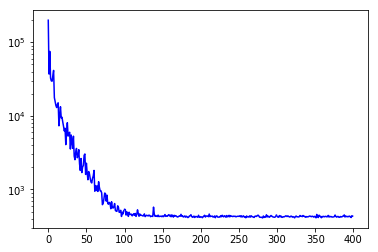

In [14]:
%matplotlib
learning_curve = []
conditions_are_met = True
loss_is_decreasing = True
i = 0
plt.ion()
while conditions_are_met:
    x_batch = next(data)[0]
    info_dict = inference.update({x_ph: x_batch})
    window = 100 # recent defined as a window one-tenth-of-all-data wide
    if i%window == 0 and i >= window:
        print(info_dict)
        ### estimate slope of recent loss
        recent_losses = learning_curve[-window:]
        #plt.scatter(np.arange(window),recent_losses)
        # estimate slope by least squares
        m_hat = np.linalg.lstsq(np.vstack([np.arange(window), np.ones(window)]).T,recent_losses)[0][0]
        # estimate standard deviation of losses in window
        s_hat = np.array(recent_losses).std(ddof=2)
        # calculate probability that slope is less than 0
        P_negative_slope = norm.cdf(0,loc=m_hat,scale=12*s_hat**2/(window**3-window))
        # if it is more than .5, loss has been decreasing
        loss_is_decreasing = P_negative_slope > .5
        #print(int(max(recent_losses)))
        #plt.axis([0, inference.n_iter, 0, int(max(recent_losses))])
        plt.semilogy(np.arange(i-window,i),recent_losses, color='blue')
    conditions_are_met = loss_is_decreasing and i < inference.n_iter
    learning_curve.append(info_dict['loss'])
    i += 1

In [15]:
print(qmumu.eval(), qmusigma.eval())
qsigma_mode = tf.exp(qsigmamu-tf.nn.softplus(qsigmasigma)**2)
print(qsigma_mode.eval())

(-2.6053963, 0.96099299)
10.3052


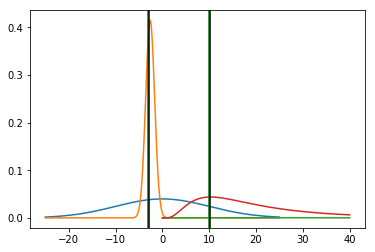

In [16]:
qmu_density = qmu.prob(mus)
qsigma_density = qsigma.prob(sigmas)
sess = ed.get_session()
qmu_density, qsigma_density = sess.run([qmu_density, qsigma_density])
plt.plot(mus,mu_density)
plt.plot(mus,qmu_density)
plt.axvline(x=mu_true, color='green')
plt.axvline(x=mu_mle, color='black')
plt.show()
plt.plot(sigmas,sigma_density)
plt.plot(sigmas,qsigma_density)
plt.axvline(x=sigma_true, color='green')
plt.axvline(x=sigma_mle, color='black')

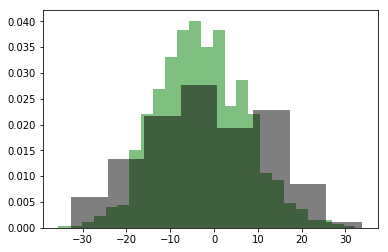

In [17]:
x_sample = ed.copy(x,{mu:qmu,sigma:qsigma}).eval()
plt.hist(x_train,'auto',alpha=.5,color='green',density=True)
plt.hist(x_sample,'auto',alpha=.5,color='black',density=True);